<a href="https://colab.research.google.com/github/sabdaaf/learning-ADS/blob/main/week3_ADS_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [191]:
# Load dataset
df = pd.read_csv('adult.csv', header=None)
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
 'hours_per_week', 'native_country', 'income']

In [192]:
# Cek data awal
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
age               0
workclass         0
fnlwgt            0
education         0
education_num

In [193]:
# Cek duplikasi data
print(df.duplicated().sum())

24


In [194]:
df.drop_duplicates(inplace=True)

In [195]:
# Cek tipe data
print(df.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object


In [196]:
# Cek imbalance (contoh untuk kolom 'income')
print(df['income'].value_counts())

income
<=50K    24698
>50K      7839
Name: count, dtype: int64


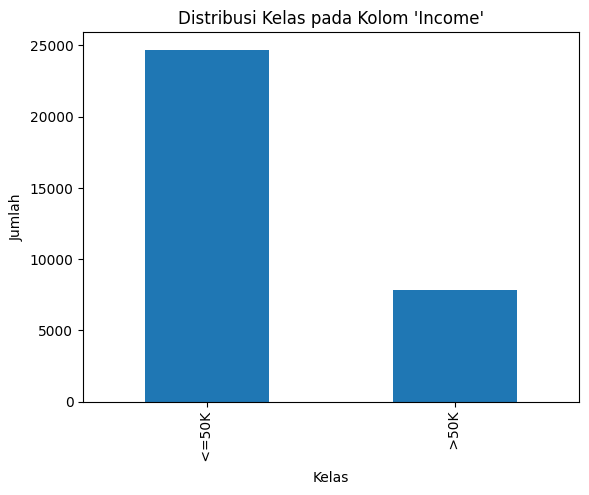

In [197]:
df['income'].value_counts().plot(kind='bar')
plt.title("Distribusi Kelas pada Kolom 'Income'")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

<ipython-input-198-d886ccbc2dd3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['income'], y=df['education_num'], palette='coolwarm')


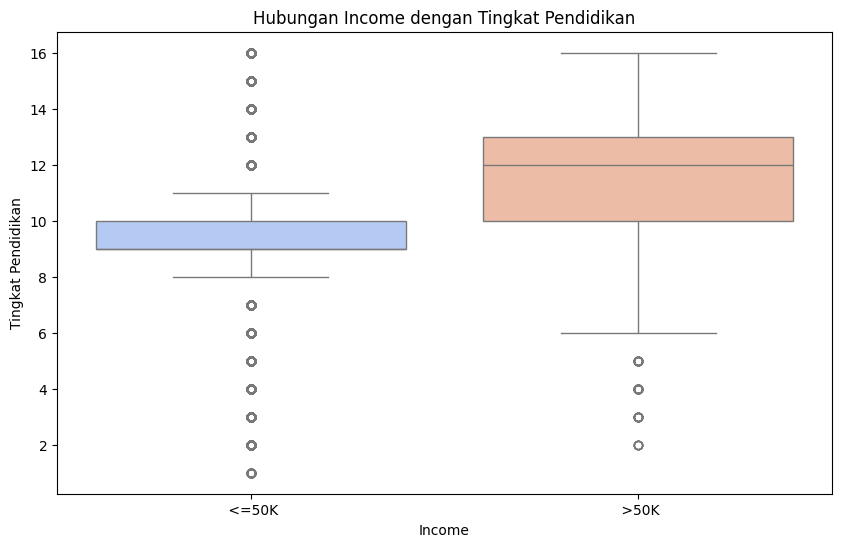

In [198]:
# Visualisasi hubungan income dengan pendidikan
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['income'], y=df['education_num'], palette='coolwarm')
plt.title('Hubungan Income dengan Tingkat Pendidikan')
plt.xlabel('Income')
plt.ylabel('Tingkat Pendidikan')
plt.show()

In [199]:
# Encoding categorical variables
ordinal_features = ['education', 'marital_status']
label_encoders = {}
for feature in ordinal_features:
    label_encoders[feature] = LabelEncoder()
    df[feature] = label_encoders[feature].fit_transform(df[feature])

nominal_features = ["workclass", "occupation", "relationship", "race", "sex", "native_country"]
df = pd.get_dummies(df, columns=nominal_features)

In [200]:
# Encoding target variable
df["income"] = df["income"].str.strip().map({"<=50K": 0, ">50K": 1})

In [201]:
# Cek hasil encoding
print(df.head())
print(df.info())

   age  fnlwgt  education  education_num  marital_status  capital_gain  \
0   39   77516          9             13               4          2174   
1   50   83311          9             13               2             0   
2   38  215646         11              9               0             0   
3   53  234721          1              7               2             0   
4   28  338409          9             13               2             0   

   capital_loss  hours_per_week  income  workclass_ ?  ...  \
0             0              40       0         False  ...   
1             0              13       0         False  ...   
2             0              40       0         False  ...   
3             0              40       0         False  ...   
4             0              40       0         False  ...   

   native_country_ Portugal  native_country_ Puerto-Rico  \
0                     False                        False   
1                     False                        False   
2 

In [202]:
for col in ['age', 'capital_gain', 'capital_loss', 'hours_per_week']:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    df[col] = np.clip(df[col], lower_bound, upper_bound)

In [203]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df[['age', 'capital_gain', 'capital_loss', 'hours_per_week']] = scaler.fit_transform(
    df[['age', 'capital_gain', 'capital_loss', 'hours_per_week']]
)


In [204]:
# Split data
X = df.drop(columns=["income"])
y = df["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [205]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [206]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)

# Evaluasi dengan cross-validation
rf_cv_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=kf, scoring='accuracy')
dt_cv_scores = cross_val_score(dt_model, X_resampled, y_resampled, cv=kf, scoring='accuracy')

print("Random Forest CV Accuracy: {:.2f} ± {:.2f}".format(rf_cv_scores.mean(), rf_cv_scores.std()))
print("Decision Tree CV Accuracy: {:.2f} ± {:.2f}".format(dt_cv_scores.mean(), dt_cv_scores.std()))


Random Forest CV Accuracy: 0.89 ± 0.00
Decision Tree CV Accuracy: 0.84 ± 0.00


In [207]:
rf_model.fit(X_resampled, y_resampled)
dt_model.fit(X_resampled, y_resampled)

DecisionTreeClassifier(random_state=42)

In [208]:
y_pred_rf = rf_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

In [209]:
def plot_confusion_matrix(y_true, y_pred, model_name, cmap):
    plt.figure(figsize=(6, 5)) # Indented this line
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap=cmap) # Indented this line
    plt.title(f'Confusion Matrix - {model_name}') # Indented this line
    plt.xlabel('Predicted') # Indented this line
    plt.ylabel('Actual') # Indented this line
    plt.show() # Indented this line


Confusion Matrix - Random Forest:
[[4902    3]
 [   0 1603]]

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4905
           1       1.00      1.00      1.00      1603

    accuracy                           1.00      6508
   macro avg       1.00      1.00      1.00      6508
weighted avg       1.00      1.00      1.00      6508



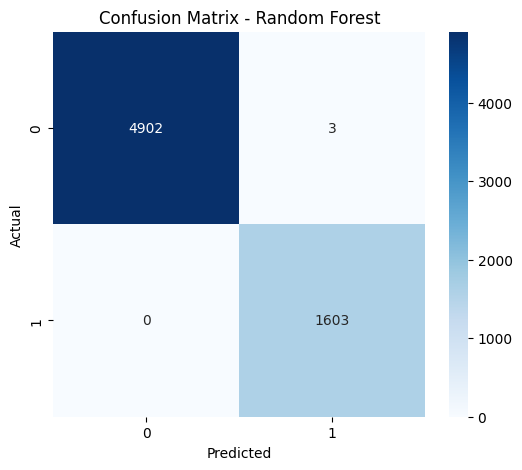


Confusion Matrix - Decision Tree:
[[4905    0]
 [   0 1603]]

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4905
           1       1.00      1.00      1.00      1603

    accuracy                           1.00      6508
   macro avg       1.00      1.00      1.00      6508
weighted avg       1.00      1.00      1.00      6508



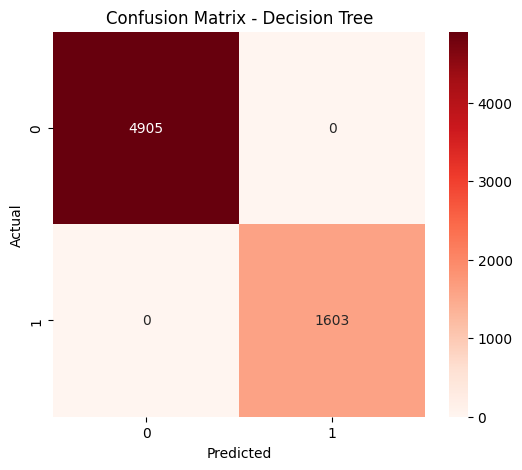

In [210]:
print("\nConfusion Matrix - Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest", "Blues")

print("\nConfusion Matrix - Decision Tree:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report - Decision Tree:")
print(classification_report(y_test, y_pred_dt))
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree", "Reds")